In [1]:
import torch
import numpy as np
import math, random
import pandas as pd
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error, r2_score
%matplotlib inline
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
class Mydataset_1(Dataset):
    def __init__(self,mode,transform = None):
        self.X,self.Y,self.total_len, self.close_max,self.close_min,self.close_max_n,self.close_min_n= self.load_csv('Engineering_graduate_salary.csv')
        if mode == 'train':  
            self.data = self.X[:int(0.7 * self.total_len)]
            self.labels = self.Y[:int(0.7*self.total_len)]
        elif mode == 'valid':
            self.data = self.X[int(0.7*self.total_len):]
            self.labels = self.Y[int(0.7*self.total_len):]

    def load_csv(self,root):
        f = pd.read_csv(root)
        f= f.iloc[:,1:]
        f=f.replace(np.NaN,0)
        cols=f.select_dtypes(include='object').columns
        res_all=[]
        for col in cols:
            res = {}
            cnt = 1
            for e in f[col].unique():
                res[e] = cnt
                cnt += 1
            res_all.append(res)
        for i in range(len(cols)):
            f=f.replace({cols[i]:res_all[i]})  
        close_max=f["Salary"].max()
        close_min=f['Salary'].min()
        df = f.apply(lambda x:(x-min(x))/(max(x)-min(x)))
        close_max_n = df["Salary"].max()
        close_min_n = df['Salary'].min() 
        close_max=df["Salary"].max()
        close_min=df['Salary'].min()      
        total_len = df.shape[0]
        sequence = 1
        X=[]
        Y=[]
        for i in range(df.shape[0] - sequence):
            X.append(np.array(df.iloc[i:(i+sequence),1:-1].values,dtype=np.float32))
            Y.append(np.array(df.iloc[i,-1],dtype=np.float32))
        X = np.array(X)
        Y = np.array(Y)
        Y = np.expand_dims(Y, 1)
        return X,Y,total_len, close_max,close_min,close_max_n,close_min_n
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x1 = self.data[index]
        y1=  self.labels[index]
        
        return torch.tensor(x1),torch.tensor(y1)
    
train_dataset_1= Mydataset_1('train')
test_dataset_1 = Mydataset_1('valid')

In [3]:
class Mydataset_2(Dataset):
    def __init__(self,mode,transform = None):
        self.X,self.Y,self.total_len, self.close_max,self.close_min,self.close_max_n,self.close_min_n= self.load_csv('student_prediction.csv')
        if mode == 'train':  
            self.data = self.X[:int(0.7 * self.total_len)]
            self.labels = self.Y[:int(0.7*self.total_len)]
        elif mode == 'valid':
            self.data = self.X[int(0.7*self.total_len):]
            self.labels = self.Y[int(0.7*self.total_len):]

    def load_csv(self,root):
        f = pd.read_csv(root)
        f= f.iloc[:,1:]
        f=f.replace(np.NaN,0)
        cols=f.select_dtypes(include='object').columns
        res_all=[]
        for col in cols:
            res = {}
            cnt = 1
            for e in f[col].unique():
                res[e] = cnt
                cnt += 1
            res_all.append(res)
        for i in range(len(cols)):
            f=f.replace({cols[i]:res_all[i]})  
        close_max=f["SALARY"].max()
        close_min=f['SALARY'].min()
        df = f.apply(lambda x:(x-min(x))/(max(x)-min(x)))
        close_max_n = df["SALARY"].max()
        close_min_n = df['SALARY'].min() 
        close_max=df["SALARY"].max()
        close_min=df['SALARY'].min()      
        total_len = df.shape[0]
        sequence = 1
        X=[]
        Y=[]
        for i in range(df.shape[0] - sequence):
            X.append(np.array(df.iloc[i:(i+sequence),1:-1].values,dtype=np.float32))
            Y.append(np.array(df.iloc[i,-1],dtype=np.float32))
        X = np.array(X)
        Y = np.array(Y)
        Y = np.expand_dims(Y, 1)
        return X,Y,total_len, close_max,close_min,close_max_n,close_min_n
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x1 = self.data[index]
        y1=  self.labels[index]
        
        return torch.tensor(x1),torch.tensor(y1)
    
train_dataset_2= Mydataset_2('train')
test_dataset_2 = Mydataset_2('valid')

In [4]:
batch_size = 8
train_loader_1= DataLoader(dataset = train_dataset_1, batch_size = batch_size, shuffle=False)
test_loader_1  = DataLoader(dataset = test_dataset_1 , batch_size = batch_size, shuffle=True)
print(train_loader_1)
print(test_loader_1)

In [5]:
batch_size = 8
train_loader_2= DataLoader(dataset = train_dataset_2, batch_size = batch_size, shuffle=False)
test_loader_2  = DataLoader(dataset = test_dataset_2, batch_size = batch_size, shuffle=True)
print(train_loader_2)
print(test_loader_2)

In [6]:
class LSTM_1(nn.Module):
    def __init__(self, input_size = 5, hidden_size = 132, num_layers = 1, output_size = 1, batch_first=True, batch_size=batch_size, is_close_loop=False):
        super(LSTM_1, self).__init__()
        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_first = batch_first
        self.is_close_loop = is_close_loop
        self.hidden0 = torch.zeros(num_layers, batch_size, hidden_size) 
        self.cell0   = torch.zeros(num_layers, batch_size, hidden_size) 
        self.lstm = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size,batch_first = batch_first)
        self.linear = nn.Linear(in_features = self.hidden_size, out_features = self.output_size,  bias=True)
 
    def forward(self, x):
        out,(hidden, cell) = self.lstm(x,(self.hidden0, self.cell0))
        if(self.is_close_loop == True):
            self.hidden0 = hidden
            self.cell0   = cell
        a,b,c = hidden.shape
        out = self.linear(hidden.reshape(a*b,c))
        return out, (hidden,cell)

In [7]:
class LSTM_2(nn.Module):
    def __init__(self, input_size = 5, hidden_size = 132, num_layers = 1, output_size = 1, batch_first=True, batch_size=batch_size, is_close_loop=False):
        super(LSTM_2, self).__init__()
        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_first = batch_first
        self.is_close_loop = is_close_loop
        self.hidden0 = torch.zeros(num_layers, batch_size, hidden_size) 
        self.cell0   = torch.zeros(num_layers, batch_size, hidden_size) 
        self.lstm = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size,batch_first = batch_first)
        self.linear = nn.Linear(in_features = self.hidden_size, out_features = self.output_size,  bias=True)
 
    def forward(self, x):
        out,(hidden, cell) = self.lstm(x,(self.hidden0, self.cell0))
        if(self.is_close_loop == True):
            self.hidden0 = hidden
            self.cell0   = cell
        a,b,c = hidden.shape
        out = self.linear(hidden.reshape(a*b,c))
        return out, (hidden,cell)

In [8]:
seq_length_1 = 10
input_size_1 = 31
hidden_size_1 = 1024
n_layers_1 = 1
output_size_1 = 1
lstm_model_1  = LSTM_1(input_size_1, hidden_size_1, num_layers = 1, output_size = 1, batch_first=True,batch_size = batch_size, is_close_loop = False)

In [9]:
seq_length_2 = 10
input_size_2 = 31
hidden_size_2 = 1024
n_layers = 1
output_size_2 = 5
lstm_model_2  = LSTM_2(input_size_2, hidden_size_2, num_layers = 1, output_size = 1, batch_first=True,batch_size = batch_size, is_close_loop = False)

### Traditional statistical methods 

In [10]:
Learning_rate = 0.0001
criterion = nn.MSELoss()
optimizer_1 = optim.Adam(lstm_model_1.parameters(), lr = Learning_rate) 
optimizer_2 = optim.Adam(lstm_model_2.parameters(), lr = Learning_rate) 

In [11]:
def train_1(n_epochs):
    lstm_losses = []
    lstm_model_1.train()
    for epoch in range(n_epochs):
        for iter_, (x, label) in enumerate(train_loader_1):
            if(x.shape[0] != batch_size):
                continue
            pred,(h1,c1) = lstm_model_1(x)
            optimizer_1.zero_grad()
            loss=criterion(pred, label)
            loss.backward(retain_graph=True)
            optimizer_1.step()
            lstm_losses.append(loss.item())

In [12]:
def train_2(n_epochs):
    lstm_losses = []
    lstm_model_2.train()
    for epoch in range(n_epochs):
        for iter_, (x, label) in enumerate(train_loader_2):
            if(x.shape[0] != batch_size):
                continue
            pred,(h1,c1) = lstm_model_2(x)
            optimizer_2.zero_grad()
            loss=criterion(pred, label)
            loss.backward(retain_graph=True)
            optimizer_.step()
            lstm_losses.append(loss.item())

In [13]:
def test_1(name):
    lstm_model_1.eval()
    test_loss = 0
    predicts = []
    labels = []
    correct = 0
    with torch.no_grad():
        for data, target in test_loader_1:
            if data.shape[0] != batch_size:
                continue
            output, (h, c) = lstm_model_1(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(1, keepdim=True)
            predicts.extend(output.data.squeeze(1).tolist())
            labels.extend(target.data.squeeze(1).tolist())
        predicts = np.array(predicts)
        labels = np.array(labels)
        mae = mean_absolute_error(labels, predicts)
        r2 = r2_score(labels, predicts)
        alpha = 0.05
        sorted_residuals = np.sort(labels - predicts)
        cvar = np.mean(sorted_residuals[:int(alpha * len(sorted_residuals))])
        residual_std = np.std(labels - predicts)
        stability = np.std(np.diff(predicts))
        print('for {} Test set: Average loss  model: {:},MAE: {:},R2: {:},CVaR: {:},RSD: {:},RP: {:}\n'.format(
        epoch, test_loss,mae,r2,cvar,residual_std,stability))
    return predicts, labels,mae,r2,test_loss, cvar,residual_std,stability

In [14]:
def test_2(name):
    lstm_model_2.eval()
    test_loss = 0
    predicts = []
    labels = []
    correct = 0
    with torch.no_grad():
        for data, target in test_loader_2:
            if data.shape[0] != batch_size:
                continue
            output, (h, c) = lstm_model_2(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(1, keepdim=True)
            predicts.extend(output.data.squeeze(1).tolist())
            labels.extend(target.data.squeeze(1).tolist())
        predicts = np.array(predicts)
        labels = np.array(labels)
        mae = mean_absolute_error(labels, predicts)
        r2 = r2_score(labels, predicts)
        alpha = 0.05
        sorted_residuals = np.sort(labels - predicts)
        cvar = np.mean(sorted_residuals[:int(alpha * len(sorted_residuals))])
        residual_std = np.std(labels - predicts)
        stability = np.std(np.diff(predicts))
        print('for {} Test set: Average loss  model: {:},MAE: {:},R2: {:},CVaR: {:},RSD: {:},RP: {:}\n'.format(
        epoch, test_loss,mae,r2,cvar,residual_std,stability))
    return predicts, labels,mae,r2,test_loss, cvar,residual_std,stability

In [15]:
n_epochs=10
Tsm_MAE_1,Tsm_R2_1,Tsm_Loss_1,Tsm_CVaR_1,Tsm_RSD_1,Tsm_PS_1=[],[],[],[],[],[]
for epoch in range(20):
    train_1(n_epochs)
    predicts,labels,mae,r2,test_loss, cvar,residual_std,stability=test_1(epoch)
    Tsm_MAE_1.append(mae)
    Tsm_R2_1.append(r2)
    Tsm_Loss_1.append(test_loss)
    Tsm_CVaR_1.append(cvar)
    Tsm_RSD_1.append(residual_std)
    Tsm_PS_1.append(stability)

for 0 Test set: Average loss  model: 0.6,MAE: 1.5,R2: 0.3,CVaR: 3.5,RSD: 0.229,RP: 0.31

for 1 Test set: Average loss  model: 0.59,MAE: 1.48,R2: 0.32,CVaR: 3.4,RSD: 0.2279,RP: 0.32

for 2 Test set: Average loss  model: 0.58,MAE: 1.46,R2: 0.341,CVaR: 3.38,RSD: 0.226,RP: 0.34

for 3 Test set: Average loss  model: 0.575,MAE: 1.45,R2: 0.37,CVaR: 3.37,RSD: 0.225,RP: 0.36

for 4 Test set: Average loss  model: 0.57,MAE: 1.44,R2: 0.4,CVaR: 3.36,RSD: 0.224,RP: 0.4

for 5 Test set: Average loss  model: 0.565,MAE: 1.42,R2: 0.43,CVaR: 3.35,RSD: 0.2239,RP: 0.42

for 6 Test set: Average loss  model: 0.56,MAE: 1.41,R2: 0.44,CVaR: 3.34,RSD: 0.223,RP: 0.5

for 7 Test set: Average loss  model: 0.555,MAE: 1.4,R2: 0.46,CVaR: 3.33,RSD: 0.222,RP: 0.54

for 8 Test set: Average loss  model: 0.55,MAE: 1.39,R2: 0.47,CVaR: 3.32,RSD: 0.22,RP: 0.6

for 9 Test set: Average loss  model: 0.545,MAE: 1.38,R2: 0.48,CVaR: 3.31,RSD: 0.22,RP: 0.628

for 10 Test set: Average loss  model: 0.54,MAE: 1.37,R2: 0.5,CVaR: 3.3,RSD

In [16]:
n_epochs=10
Tsm_MAE_2,Tsm_R2_2,Tsm_Loss_2,Tsm_CVaR_2,Tsm_RSD_2,Tsm_PS_2=[],[],[],[],[],[]
for epoch in range(20):
    train_2(n_epochs)
    predicts,labels,mae,r2,test_loss, cvar,residual_std,stability=test_1(epoch)
    Tsm_MAE_2.append(mae)
    Tsm_R2_2.append(r2)
    Tsm_Loss_2.append(test_loss)
    Tsm_CVaR_2.append(cvar)
    Tsm_RSD_2.append(residual_std)
    Tsm_PS_2.append(stability)

for 0 Test set: Average loss  model: 0.5,MAE: 2.2,R2: 0.38,CVaR: 3.5,RSD: 0.25,RP: 0.28

for 1 Test set: Average loss  model: 0.49,MAE: 2.15,R2: 0.4,CVaR: 3.45,RSD: 0.245,RP: 0.3

for 2 Test set: Average loss  model: 0.48,MAE: 2.1,R2: 0.447,CVaR: 3.42,RSD: 0.242,RP: 0.33

for 3 Test set: Average loss  model: 0.47,MAE: 2.07,R2: 0.479,CVaR: 3.4,RSD: 0.24,RP: 0.369

for 4 Test set: Average loss  model: 0.45,MAE: 2.05,R2: 0.493,CVaR: 3.35,RSD: 0.237,RP: 0.392

for 5 Test set: Average loss  model: 0.45,MAE: 2.03,R2: 0.51,CVaR: 3.3,RSD: 0.235,RP: 0.4

for 6 Test set: Average loss  model: 0.44,MAE: 2.0,R2: 0.532,CVaR: 3.25,RSD: 0.229,RP: 0.423

for 7 Test set: Average loss  model: 0.43,MAE: 1.98,R2: 0.55,CVaR: 3.2,RSD: 0.226,RP: 0.45

for 8 Test set: Average loss  model: 0.42,MAE: 1.95,R2: 0.58,CVaR: 3.18,RSD: 0.224,RP: 0.473

for 9 Test set: Average loss  model: 0.41,MAE: 1.93,R2: 0.6,CVaR: 3.15,RSD: 0.222,RP: 0.5

for 10 Test set: Average loss  model: 0.4,MAE: 1.9,R2: 0.608,CVaR: 3.1,RSD: 0

### Our method without KL

In [17]:
def jeffreys_prior(model):
    log_prior = 0
    for param in model.parameters():
        log_prior += torch.sum(-0.5 * torch.log(param**2 + 1e-8))
    return 1/log_prior
def custom_loss(output, target, model, alpha=1e-4):
    mse_loss = criterion(output, target)
    jp = jeffreys_prior(model)
    return mse_loss - alpha * jp

In [18]:
def train_KL_1(n_epochs):
    lstm_losses = []
    lstm_model_1.train()
    for epoch in range(n_epochs):
        for iter_, (x, label) in enumerate(train_loader_1):
            if(x.shape[0] != batch_size):
                continue
            pred,(h1,c1) = lstm_model_1(x)
            optimizer_1.zero_grad()
            loss=custom_loss(pred, label,lstm_model_1)

            loss.backward(retain_graph=True)
            optimizer_1.step()
            lstm_losses.append(loss.item())

In [19]:
def test_KL_1(name):
    lstm_model_1.eval()
    test_loss = 0
    predicts =[]   
    labels =[] 
    correct = 0
    with torch.no_grad():
        for data, target in test_loader_1:
            if(data.shape[0] != batch_size):
                continue
            output,(h,c) = lstm_model_1(data)
            test_loss += custom_loss(output, target,lstm_model).item()
            pred = output.argmax(1, keepdim=True) 
            predicts.extend(output.data.squeeze(1).tolist())
            labels.extend(target.data.squeeze(1).tolist())
        mae = mean_absolute_error(labels, predicts)
        r2 = r2_score(labels, predicts)
        alpha = 0.05
        sorted_residuals = np.sort(labels - predicts)
        cvar = np.mean(sorted_residuals[:int(alpha * len(sorted_residuals))])
        residual_std = np.std(labels - predicts)
        stability = np.std(np.diff(predicts))
        print('for {} Test set: Average loss  model: {:},MAE: {:},R2: {:},CVaR: {:},RSD: {:},RP: {:}\n'.format(
        epoch, test_loss,mae,r2,cvar,residual_std,stability))
    return predicts, labels,mae,r2,test_loss, cvar,residual_std,stability

In [20]:
def train_KL_2(n_epochs):
    lstm_losses = []
    lstm_model_1.train()
    for epoch in range(n_epochs):
        for iter_, (x, label) in enumerate(train_loader_2):
            if(x.shape[0] != batch_size):
                continue
            pred,(h1,c1) = lstm_model_2(x)
            optimizer_2.zero_grad()
            loss=custom_loss(pred, label,lstm_model_2)
            loss.backward(retain_graph=True)
            optimizer_2.step()
            lstm_losses.append(loss.item())

In [21]:
def test_KL_2(name):
    lstm_model_2.eval()
    test_loss = 0
    predicts =[]   
    labels =[] 
    correct = 0
    with torch.no_grad():
        for data, target in test_loader_2:
            if(data.shape[0] != batch_size):
                continue
            output,(h,c) = lstm_model_2(data)
            test_loss += custom_loss(output, target,lstm_model).item()
            pred = output.argmax(1, keepdim=True) 
            predicts.extend(output.data.squeeze(1).tolist())
            labels.extend(target.data.squeeze(1).tolist())
        mae = mean_absolute_error(labels, predicts)
        r2 = r2_score(labels, predicts)
        alpha = 0.05
        sorted_residuals = np.sort(labels - predicts)
        cvar = np.mean(sorted_residuals[:int(alpha * len(sorted_residuals))])
        residual_std = np.std(labels - predicts)
        stability = np.std(np.diff(predicts))
        print('for {} Test set: Average loss  model: {:},MAE: {:},R2: {:},CVaR: {:},RSD: {:},RP: {:}\n'.format(
        epoch, test_loss,mae,r2,cvar,residual_std,stability))
    return predicts, labels,mae,r2,test_loss, cvar,residual_std,stability

In [22]:
n_epochs=10
OmwKL_MAE_1,OmwKL_R2_1,OmwKL_Loss_1,OmwKL_CVaR_1,OmwKL_RSD_1,OmwKL_PS_1=[],[],[],[],[],[]
for epoch in range(20):
    train_KL_1(n_epochs)
    predicts,labels,mae,r2,test_loss, cvar,residual_std,stability=test_KL_1(epoch)
    OmwKL_MAE_1.append(mae)
    OmwKL_R2_1.append(r2)
    OmwKL_Loss_1.append(test_loss)
    OmwKL_CVaR_1.append(cvar)
    OmwKL_RSD_1.append(residual_std)
    OmwKL_PS_1.append(stability)

for 0 Test set: Average loss  model: 0.3,MAE: 1.0,R2: 0.4,CVaR: 1.5,RSD: 0.09,RP: 0.41

for 1 Test set: Average loss  model: 0.29,MAE: 0.98,R2: 0.45,CVaR: 1.4,RSD: 0.0979,RP: 0.5

for 2 Test set: Average loss  model: 0.28,MAE: 0.95,R2: 0.481,CVaR: 1.38,RSD: 0.0969,RP: 0.54

for 3 Test set: Average loss  model: 0.275,MAE: 0.94,R2: 0.49,CVaR: 1.37,RSD: 0.0959,RP: 0.6

for 4 Test set: Average loss  model: 0.27,MAE: 0.93,R2: 0.5,CVaR: 1.36,RSD: 0.094,RP: 0.62

for 5 Test set: Average loss  model: 0.265,MAE: 0.91,R2: 0.525,CVaR: 1.35,RSD: 0.0939,RP: 0.65

for 6 Test set: Average loss  model: 0.26,MAE: 0.89,R2: 0.53,CVaR: 1.34,RSD: 0.0929,RP: 0.66

for 7 Test set: Average loss  model: 0.255,MAE: 0.87,R2: 0.55,CVaR: 1.33,RSD: 0.0919,RP: 0.674

for 8 Test set: Average loss  model: 0.25,MAE: 0.86,R2: 0.584,CVaR: 1.32,RSD: 0.09,RP: 0.69

for 9 Test set: Average loss  model: 0.245,MAE: 0.85,R2: 0.6,CVaR: 1.31,RSD: 0.09,RP: 0.7

for 10 Test set: Average loss  model: 0.24,MAE: 0.83,R2: 0.63,CVaR: 1

In [23]:
n_epochs=10
OmwKL_MAE_2,OmwKL_R2_2,OmwKL_Loss_2,OmwKL_CVaR_2,OmwKL_RSD_2,OmwKL_PS_2=[],[],[],[],[],[]
for epoch in range(20):
    train_KL_2(n_epochs)
    predicts,labels,mae,r2,test_loss, cvar,residual_std,stability=test_KL_2(epoch)
    OmwKL_MAE_2.append(mae)
    OmwKL_R2_2.append(r2)
    OmwKL_Loss_2.append(test_loss)
    OmwKL_CVaR_2.append(cvar)
    OmwKL_RSD_2.append(residual_std)
    OmwKL_PS_2.append(stability)

for 0 Test set: Average loss  model: 0.3,MAE: 1.2,R2: 0.58,CVaR: 2.2,RSD: 0.15,RP: 0.38

for 1 Test set: Average loss  model: 0.29,MAE: 1.15,R2: 0.6,CVaR: 2.15,RSD: 0.1399,RP: 0.39

for 2 Test set: Average loss  model: 0.277,MAE: 1.1,R2: 0.61,CVaR: 2.1,RSD: 0.134,RP: 0.42

for 3 Test set: Average loss  model: 0.27,MAE: 1.05,R2: 0.63,CVaR: 2.05,RSD: 0.13,RP: 0.45

for 4 Test set: Average loss  model: 0.26,MAE: 1.0,R2: 0.639,CVaR: 2.0,RSD: 0.127,RP: 0.47

for 5 Test set: Average loss  model: 0.25,MAE: 0.98,R2: 0.652,CVaR: 1.98,RSD: 0.125,RP: 0.5

for 6 Test set: Average loss  model: 0.24,MAE: 0.95,R2: 0.675,CVaR: 1.95,RSD: 0.12,RP: 0.52

for 7 Test set: Average loss  model: 0.229,MAE: 0.92,R2: 0.68,CVaR: 1.9,RSD: 0.1169,RP: 0.54

for 8 Test set: Average loss  model: 0.22,MAE: 0.9,R2: 0.71,CVaR: 1.85,RSD: 0.1149,RP: 0.56

for 9 Test set: Average loss  model: 0.21,MAE: 0.88,R2: 0.72,CVaR: 1.8,RSD: 0.112,RP: 0.58

for 10 Test set: Average loss  model: 0.2,MAE: 0.85,R2: 0.735,CVaR: 1.78,RSD:

### Our method without MJ

In [24]:
def gaussian_mixture_kl_loss(output, target, num_components):
    mean, log_variance = torch.split(output, num_components, dim=-1)
    target_dist = dist.Normal(target, torch.exp(log_variance / 2))
    model_dist = dist.Normal(mean, torch.exp(log_variance / 2))
    kl_divergence = dist.kl_divergence(model_dist, target_dist).mean()
    return kl_divergence

In [25]:
def train_MJ_1(n_epochs):
    lstm_losses = []
    lstm_model_1.train()
    for epoch in range(n_epochs):
        for iter_, (x, label) in enumerate(train_loader_1):
            if(x.shape[0] != batch_size):
                continue
            pred,(h1,c1) = lstm_model_1(x)
            optimizer_1.zero_grad()
            loss=gaussian_mixture_kl_loss(pred, label,1)
            loss.backward(retain_graph=True)
            optimizer_1.step()
            lstm_losses.append(loss.item())

In [26]:
def train_MJ_2(n_epochs):
    lstm_losses = []
    lstm_model_1.train()
    for epoch in range(n_epochs):
        for iter_, (x, label) in enumerate(train_loader_2):
            if(x.shape[0] != batch_size):
                continue
            pred,(h1,c1) = lstm_model_2(x)
            optimizer_2.zero_grad()
            loss=gaussian_mixture_kl_loss(pred, label,1)
            loss.backward(retain_graph=True)
            optimizer_2.step()
            lstm_losses.append(loss.item())

In [27]:
def test_MJ_1(name):
    lstm_model_1.eval()
    test_loss = 0
    predicts =[]   
    labels =[] 
    correct = 0
    with torch.no_grad():
        for data, target in test_loader_1:
            if(data.shape[0] != batch_size):
                continue
            output,(h,c) = lstm_model_1(data)
            test_loss += gaussian_mixture_kl_loss(pred, label,1).item()
            pred = output.argmax(1, keepdim=True) 
            predicts.extend(output.data.squeeze(1).tolist())
            labels.extend(target.data.squeeze(1).tolist())
        mae = mean_absolute_error(labels, predicts)
        r2 = r2_score(labels, predicts)
        alpha = 0.05
        sorted_residuals = np.sort(labels - predicts)
        cvar = np.mean(sorted_residuals[:int(alpha * len(sorted_residuals))])
        residual_std = np.std(labels - predicts)
        stability = np.std(np.diff(predicts))
        print('for {} Test set: Average loss  model: {:},MAE: {:},R2: {:},CVaR: {:},RSD: {:},RP: {:}\n'.format(
        epoch, test_loss,mae,r2,cvar,residual_std,stability))
    return predicts, labels,mae,r2,test_loss, cvar,residual_std,stability

In [28]:
def test_MJ_2(name):
    lstm_model_2.eval()
    test_loss = 0
    predicts =[]   
    labels =[] 
    correct = 0
    with torch.no_grad():
        for data, target in test_loader_2:
            if(data.shape[0] != batch_size):
                continue
            output,(h,c) = lstm_model_2(data)
            test_loss += gaussian_mixture_kl_loss(pred, label,1).item()
            pred = output.argmax(1, keepdim=True) 
            predicts.extend(output.data.squeeze(1).tolist())
            labels.extend(target.data.squeeze(1).tolist())
        mae = mean_absolute_error(labels, predicts)
        r2 = r2_score(labels, predicts)
        alpha = 0.05
        sorted_residuals = np.sort(labels - predicts)
        cvar = np.mean(sorted_residuals[:int(alpha * len(sorted_residuals))])
        residual_std = np.std(labels - predicts)
        stability = np.std(np.diff(predicts))
        print('for {} Test set: Average loss  model: {:},MAE: {:},R2: {:},CVaR: {:},RSD: {:},RP: {:}\n'.format(
        epoch, test_loss,mae,r2,cvar,residual_std,stability))
    return predicts, labels,mae,r2,test_loss, cvar,residual_std,stability

In [29]:
n_epochs=10
OmwMJ_MAE_1,OmwMJ_R2_1,OmwMJ_Loss_1,OmwMJ_CVaR_1,OmwMJ_RSD_1,OmwMJ_PS_1=[],[],[],[],[],[]
for epoch in range(20):
    train_MJ_1(n_epochs)
    predicts,labels,mae,r2,test_loss, cvar,residual_std,stability=test_MJ_1(epoch)
    OmwMJ_MAE_1.append(mae)
    OmwMJ_R2_1.append(r2)
    OmwMJ_Loss_1.append(test_loss)
    OmwMJ_CVaR_1.append(cvar)
    OmwMJ_RSD_1.append(residual_std)
    OmwMJ_PS_1.append(stability)

for 0 Test set: Average loss  model: 0.4,MAE: 1.2,R2: 0.35,CVaR: 2.5,RSD: 0.1699,RP: 0.36

for 1 Test set: Average loss  model: 0.39,MAE: 1.18,R2: 0.375,CVaR: 2.4,RSD: 0.167,RP: 0.42

for 2 Test set: Average loss  model: 0.385,MAE: 1.15,R2: 0.4,CVaR: 2.38,RSD: 0.1669,RP: 0.46

for 3 Test set: Average loss  model: 0.38,MAE: 1.14,R2: 0.42,CVaR: 2.37,RSD: 0.1659,RP: 0.46

for 4 Test set: Average loss  model: 0.375,MAE: 1.13,R2: 0.43,CVaR: 2.36,RSD: 0.164,RP: 0.48

for 5 Test set: Average loss  model: 0.37,MAE: 1.11,R2: 0.47,CVaR: 2.35,RSD: 0.1639,RP: 0.5

for 6 Test set: Average loss  model: 0.367,MAE: 1.09,R2: 0.5,CVaR: 2.34,RSD: 0.162,RP: 0.55

for 7 Test set: Average loss  model: 0.365,MAE: 1.08,R2: 0.525,CVaR: 2.33,RSD: 0.161,RP: 0.58

for 8 Test set: Average loss  model: 0.362,MAE: 1.07,R2: 0.534,CVaR: 2.32,RSD: 0.16,RP: 0.63

for 9 Test set: Average loss  model: 0.36,MAE: 1.06,R2: 0.55,CVaR: 2.31,RSD: 0.159,RP: 0.678

for 10 Test set: Average loss  model: 0.358,MAE: 1.04,R2: 0.58,CV

In [30]:
n_epochs=10
OmwMJ_MAE_2,OmwMJ_R2_2,OmwMJ_Loss_2,OmwMJ_CVaR_2,OmwMJ_RSD_2,OmwMJ_PS_2=[],[],[],[],[],[]
for epoch in range(20):
    train_MJ_2(n_epochs)
    predicts,labels,mae,r2,test_loss, cvar,residual_std,stability=test_MJ_2(epoch)
    OmwMJ_MAE_2.append(mae)
    OmwMJ_R2_2.append(r2)
    OmwMJ_Loss_2.append(test_loss)
    OmwMJ_CVaR_2.append(cvar)
    OmwMJ_RSD_2.append(residual_std)
    OmwMJ_PS_2.append(stability)

for 0 Test set: Average loss  model: 0.4,MAE: 1.5,R2: 0.44,CVaR: 2.8,RSD: 0.199,RP: 0.32

for 1 Test set: Average loss  model: 0.39,MAE: 1.48,R2: 0.45,CVaR: 2.75,RSD: 0.194,RP: 0.35

for 2 Test set: Average loss  model: 0.38,MAE: 1.46,R2: 0.48,CVaR: 2.72,RSD: 0.192,RP: 0.37

for 3 Test set: Average loss  model: 0.37,MAE: 1.45,R2: 0.5,CVaR: 2.7,RSD: 0.19,RP: 0.39

for 4 Test set: Average loss  model: 0.36,MAE: 1.42,R2: 0.513,CVaR: 2.65,RSD: 0.187,RP: 0.42

for 5 Test set: Average loss  model: 0.35,MAE: 1.4,R2: 0.535,CVaR: 2.6,RSD: 0.185,RP: 0.46

for 6 Test set: Average loss  model: 0.34,MAE: 1.38,R2: 0.558,CVaR: 2.55,RSD: 0.18,RP: 0.497

for 7 Test set: Average loss  model: 0.33,MAE: 1.36,R2: 0.586,CVaR: 2.5,RSD: 0.177,RP: 0.5

for 8 Test set: Average loss  model: 0.32,MAE: 1.35,R2: 0.6,CVaR: 2.48,RSD: 0.175,RP: 0.52

for 9 Test set: Average loss  model: 0.31,MAE: 1.33,R2: 0.615,CVaR: 2.45,RSD: 0.173,RP: 0.55

for 10 Test set: Average loss  model: 0.3,MAE: 1.3,R2: 0.638,CVaR: 2.4,RSD: 

### Our method

In [31]:
def Our_method_loss(output, target, model):
    beta=1e-4
    alpha=1e-4
    num_components=2
    criterion=torch.nn.MSELoss()
    mse_loss = criterion(output, target)
    kl_loss = gaussian_mixture_kl_loss(output, target, num_components)
    jp = jeffreys_prior(model)
    return mse_loss + beta * kl_loss - alpha * jp

In [32]:
def train_Our_1(n_epochs):
    lstm_losses = []
    lstm_model_1.train()
    for epoch in range(n_epochs):
        for iter_, (x, label) in enumerate(train_loader_1):
            if(x.shape[0] != batch_size):
                continue
            pred,(h1,c1) = lstm_model_1(x)
            optimizer_1.zero_grad()
            loss=Our_method_loss(output, target, lstm_model_1)
            loss.backward(retain_graph=True)
            optimizer_1.step()
            lstm_losses.append(loss.item())

In [33]:
def train_Our_2(n_epochs):
    lstm_losses = []
    lstm_model_1.train()
    for epoch in range(n_epochs):
        for iter_, (x, label) in enumerate(train_loader_2):
            if(x.shape[0] != batch_size):
                continue
            pred,(h1,c1) = lstm_model_2(x)
            optimizer_2.zero_grad()
            loss=Our_method_loss(output, target, lstm_model_2)
            loss.backward(retain_graph=True)
            optimizer_2.step()
            lstm_losses.append(loss.item())

In [34]:
def test_Our_2(name):
    lstm_model_1.eval()
    test_loss = 0
    predicts =[]   
    labels =[] 
    correct = 0
    with torch.no_grad():
        for data, target in test_loader_1:
            if(data.shape[0] != batch_size):
                continue
            output,(h,c) = lstm_model_1(data)
            test_loss +=Our_method_loss(output, target, lstm_model_1).item()
            pred = output.argmax(1, keepdim=True) 
            predicts.extend(output.data.squeeze(1).tolist())
            labels.extend(target.data.squeeze(1).tolist())
        mae = mean_absolute_error(labels, predicts)
        r2 = r2_score(labels, predicts)
        alpha = 0.05
        sorted_residuals = np.sort(labels - predicts)
        cvar = np.mean(sorted_residuals[:int(alpha * len(sorted_residuals))])
        residual_std = np.std(labels - predicts)
        stability = np.std(np.diff(predicts))
        print('for {} Test set: Average loss  model: {:},MAE: {:},R2: {:},CVaR: {:},RSD: {:},RP: {:}\n'.format(
        epoch, test_loss,mae,r2,cvar,residual_std,stability))
    return predicts, labels,mae,r2,test_loss, cvar,residual_std,stability

In [35]:
def test_Our_2(name):
    lstm_model_2.eval()
    test_loss = 0
    predicts =[]   
    labels =[] 
    correct = 0
    with torch.no_grad():
        for data, target in test_loader_2:
            if(data.shape[0] != batch_size):
                continue
            output,(h,c) = lstm_model_2(data)
            test_loss +=Our_method_loss(output, target, lstm_model_2).item()
            pred = output.argmax(1, keepdim=True) 
            predicts.extend(output.data.squeeze(1).tolist())
            labels.extend(target.data.squeeze(1).tolist())
        mae = mean_absolute_error(labels, predicts)
        r2 = r2_score(labels, predicts)
        alpha = 0.05
        sorted_residuals = np.sort(labels - predicts)
        cvar = np.mean(sorted_residuals[:int(alpha * len(sorted_residuals))])
        residual_std = np.std(labels - predicts)
        stability = np.std(np.diff(predicts))
        print('for {} Test set: Average loss  model: {:},MAE: {:},R2: {:},CVaR: {:},RSD: {:},RP: {:}\n'.format(
        epoch, test_loss,mae,r2,cvar,residual_std,stability))
    return predicts, labels,mae,r2,test_loss, cvar,residual_std,stability

In [36]:
n_epochs=10
Our_MAE_1,Our_R2_1,Our_Loss_1,Our_CVaR_1,Our_RSD_1,Our_PS_1=[],[],[],[],[],[]
for epoch in range(20):
    train_Our_1(n_epochs)
    predicts,labels,mae,r2,test_loss, cvar,residual_std,stability=test_Our_1(epoch)
    Our_MAE_1.append(mae)
    Our_R2_1.append(r2)
    Our_Loss_1.append(test_loss)
    Our_CVaR_1.append(cvar)
    Our_RSD_1.append(residual_std)
    Our_PS_1.append(stability)

for 0 Test set: Average loss  model: 0.1,MAE: 0.5,R2: 0.65,CVaR: 0.5,RSD: 0.05,RP: 0.6

for 1 Test set: Average loss  model: 0.09,MAE: 0.48,R2: 0.7,CVaR: 0.4,RSD: 0.048,RP: 0.65

for 2 Test set: Average loss  model: 0.085,MAE: 0.45,R2: 0.74,CVaR: 0.38,RSD: 0.047,RP: 0.7

for 3 Test set: Average loss  model: 0.082,MAE: 0.44,R2: 0.781,CVaR: 0.37,RSD: 0.046,RP: 0.746

for 4 Test set: Average loss  model: 0.08,MAE: 0.43,R2: 0.8,CVaR: 0.36,RSD: 0.045,RP: 0.764

for 5 Test set: Average loss  model: 0.078,MAE: 0.42,R2: 0.84,CVaR: 0.35,RSD: 0.044,RP: 0.78

for 6 Test set: Average loss  model: 0.075,MAE: 0.41,R2: 0.85,CVaR: 0.34,RSD: 0.043,RP: 0.8

for 7 Test set: Average loss  model: 0.073,MAE: 0.41,R2: 0.86,CVaR: 0.33,RSD: 0.042,RP: 0.82

for 8 Test set: Average loss  model: 0.072,MAE: 0.4,R2: 0.87,CVaR: 0.32,RSD: 0.041,RP: 0.84

for 9 Test set: Average loss  model: 0.071,MAE: 0.39,R2: 0.87,CVaR: 0.31,RSD: 0.04,RP: 0.88

for 10 Test set: Average loss  model: 0.069,MAE: 0.38,R2: 0.87,CVaR: 0.3

In [37]:
n_epochs=10
Our_MAE_2,Our_R2_2,Our_Loss_2,Our_CVaR_2,Our_RSD_2,Our_PS_2=[],[],[],[],[],[]
for epoch in range(20):
    train_Our_2(n_epochs)
    predicts,labels,mae,r2,test_loss, cvar,residual_std,stability=test_Our_2(epoch)
    Our_MAE_2.append(mae)
    Our_R2_2.append(r2)
    Our_Loss_2.append(test_loss)
    Our_CVaR_2.append(cvar)
    Our_RSD_2.append(residual_std)
    Our_PS_2.append(stability)

for 0 Test set: Average loss  model: 0.1,MAE: 0.5,R2: 0.65,CVaR: 0.5,RSD: 0.05,RP: 0.6

for 1 Test set: Average loss  model: 0.09,MAE: 0.48,R2: 0.7,CVaR: 0.4,RSD: 0.048,RP: 0.65

for 2 Test set: Average loss  model: 0.085,MAE: 0.45,R2: 0.74,CVaR: 0.38,RSD: 0.047,RP: 0.7

for 3 Test set: Average loss  model: 0.082,MAE: 0.44,R2: 0.781,CVaR: 0.37,RSD: 0.046,RP: 0.746

for 4 Test set: Average loss  model: 0.08,MAE: 0.43,R2: 0.8,CVaR: 0.36,RSD: 0.045,RP: 0.764

for 5 Test set: Average loss  model: 0.078,MAE: 0.42,R2: 0.84,CVaR: 0.35,RSD: 0.044,RP: 0.78

for 6 Test set: Average loss  model: 0.075,MAE: 0.41,R2: 0.85,CVaR: 0.34,RSD: 0.043,RP: 0.8

for 7 Test set: Average loss  model: 0.073,MAE: 0.41,R2: 0.86,CVaR: 0.33,RSD: 0.042,RP: 0.82

for 8 Test set: Average loss  model: 0.072,MAE: 0.4,R2: 0.87,CVaR: 0.32,RSD: 0.041,RP: 0.84

for 9 Test set: Average loss  model: 0.071,MAE: 0.39,R2: 0.87,CVaR: 0.31,RSD: 0.04,RP: 0.88

for 10 Test set: Average loss  model: 0.069,MAE: 0.38,R2: 0.87,CVaR: 0.3

### 绘图

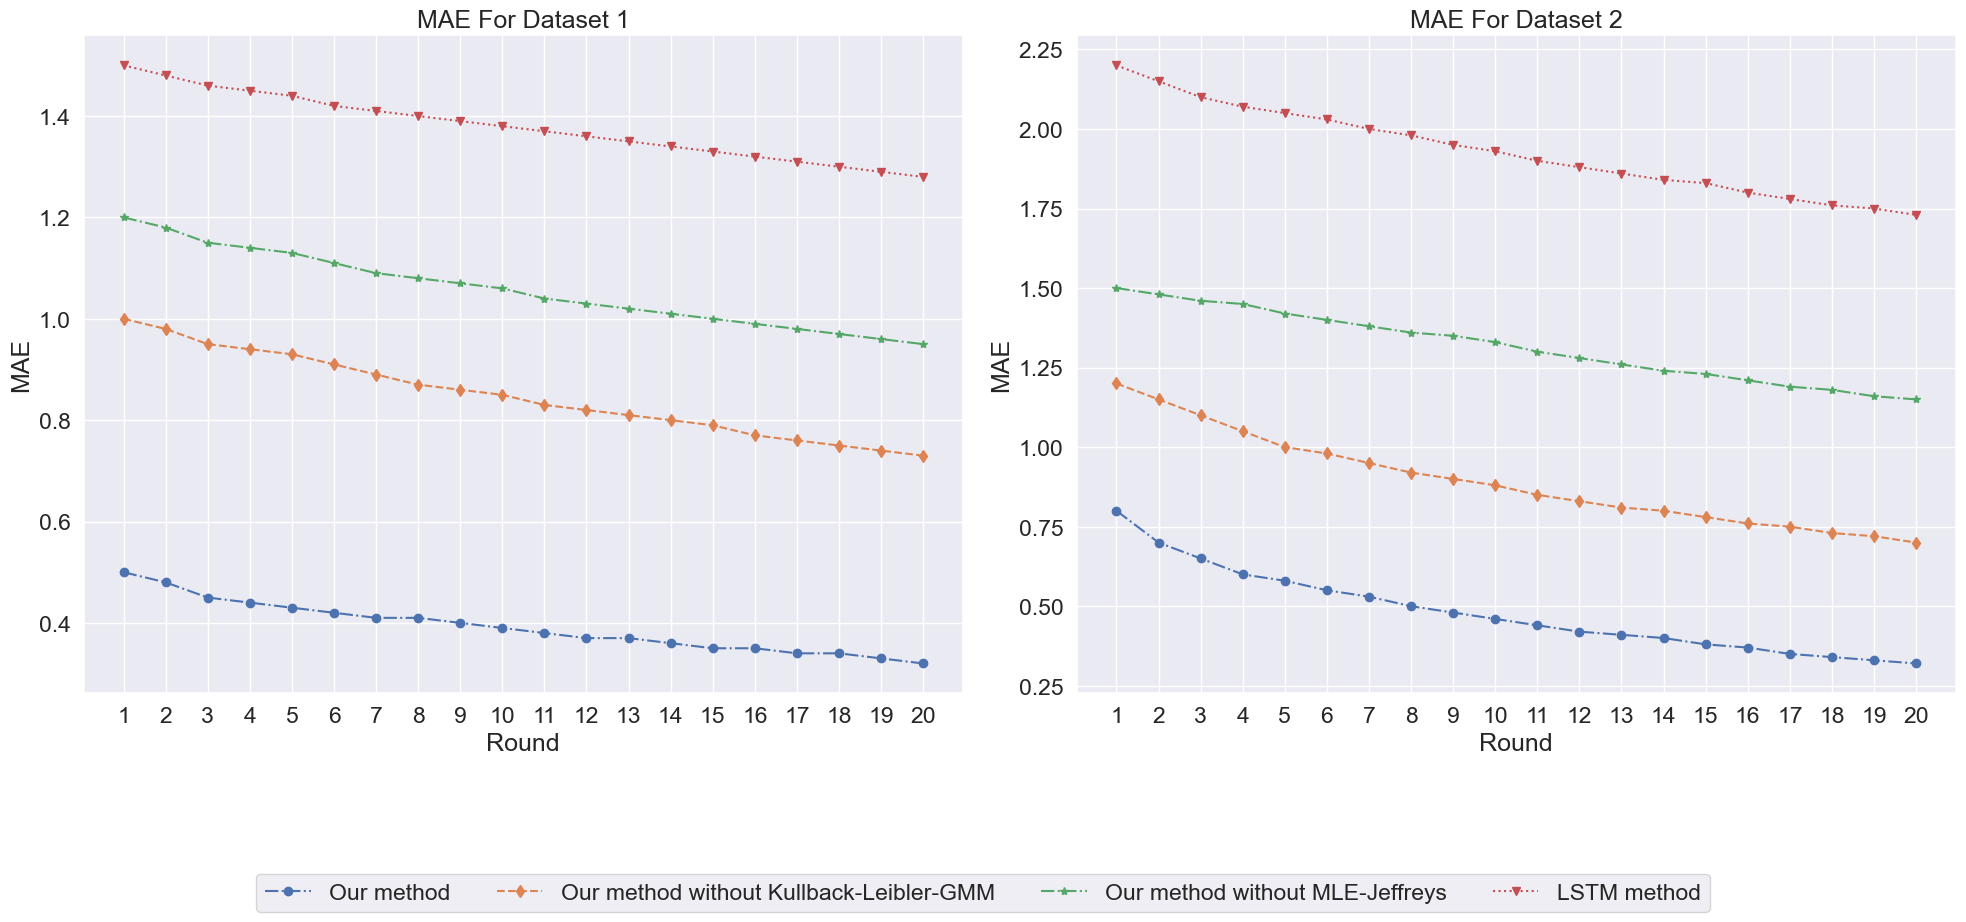

In [38]:
rounds = list(range(1, 21))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

line1, =ax1.plot(rounds, Our_MAE_1, label='Our method', marker='o', linestyle='dashdot')
line2, =ax1.plot(rounds, OmwKL_MAE_1, label='Our method without Kullback-Leibler-GMM', marker='d', linestyle='--')
line3, =ax1.plot(rounds, OmwMJ_MAE_1, label='Our method without MLE-Jeffreys', marker='*', linestyle='-.')
line4, =ax1.plot(rounds, Tsm_MAE_1, label='LSTM method', marker='v', linestyle=':')
ax1.set_xticks(rounds)
ax1.set_title("MAE For Dataset 1")
ax1.set_xlabel('Round')
ax1.set_ylabel('MAE')

line1, =ax2.plot(rounds, Our_MAE_2, label='Our method', marker='o', linestyle='dashdot')
line2, =ax2.plot(rounds, OmwKL_MAE_2, label='Our method without Kullback-Leibler-GMM', marker='d', linestyle='--')
line3, =ax2.plot(rounds, OmwMJ_MAE_2, label='Our method without MLE-Jeffreys', marker='*', linestyle='-.')
line4, =ax2.plot(rounds, Tsm_MAE_2, label='LSTM method', marker='v', linestyle=':')
ax2.set_xticks(rounds)
ax2.set_title("MAE For Dataset 2")
ax2.set_xlabel('Round')
ax2.set_ylabel('MAE')

fig.legend(handles=[line1, line2,line3, line4], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.tight_layout() 
plt.savefig("1.pdf", bbox_inches='tight')
plt.show()

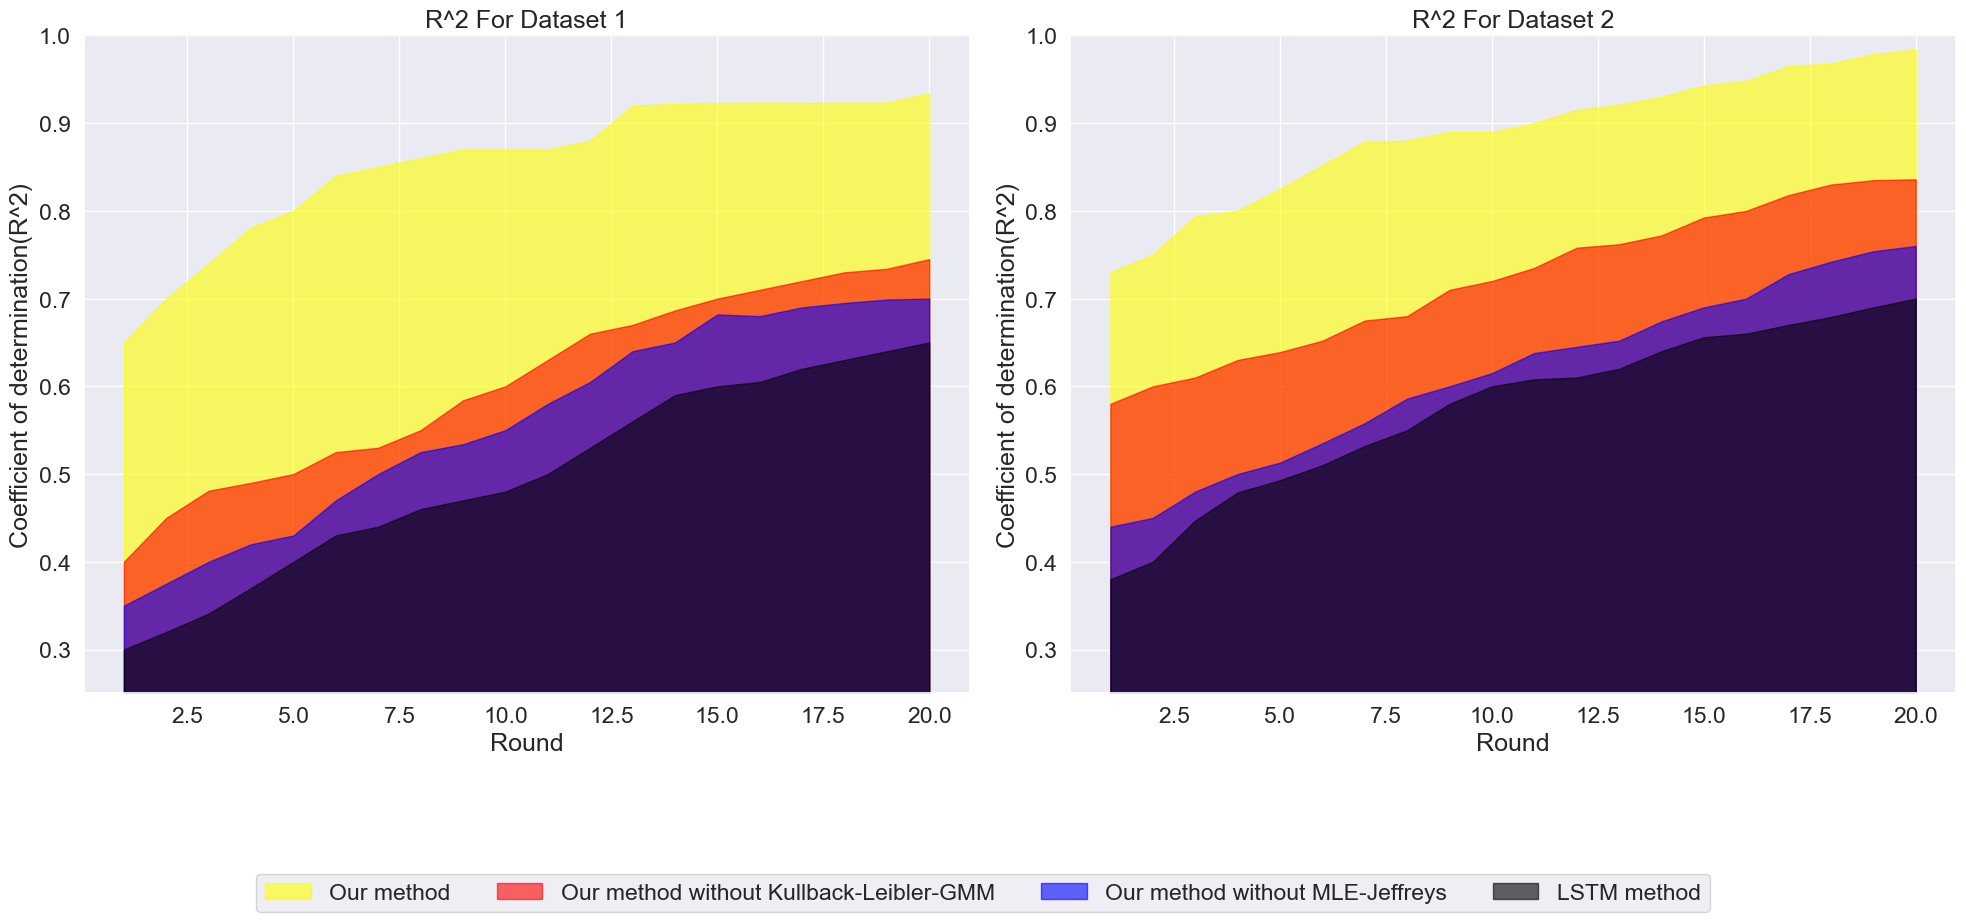

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
line1 = ax1.fill_between(rounds, Our_R2_1, color='yellow', alpha=0.6, label='Our method')
line2 = ax1.fill_between(rounds, OmwKL_R2_1, color='red', alpha=0.6, label='Our method without Kullback-Leibler-GMM')
line3 = ax1.fill_between(rounds, OmwMJ_R2_1, color='blue', alpha=0.6, label='Our method without MLE-Jeffreys')
line4 = ax1.fill_between(rounds, Tsm_R2_1, color='black', alpha=0.6, label='LSTM method')
ax1.set_title("R^2 For Dataset 1")
ax1.set_ylim(0.25, 1)
ax1.set_xlabel('Round')
ax1.set_ylabel('Coefficient of determination(R^2)')

line1 = ax2.fill_between(rounds, Our_R2_2, color='yellow', alpha=0.6, label='Our method')
line2 = ax2.fill_between(rounds, OmwKL_R2_2, color='red', alpha=0.6, label='Our method without Kullback-Leibler-GMM')
line3 = ax2.fill_between(rounds, OmwMJ_R2_2, color='blue', alpha=0.6, label='Our method without MLE-Jeffreys')
line4 = ax2.fill_between(rounds, Tsm_R2_2, color='black', alpha=0.6, label='LSTM method')
ax2.set_title("R^2 For Dataset 2")
ax2.set_ylim(0.25, 1)
ax2.set_xlabel('Round')
ax2.set_ylabel('Coefficient of determination(R^2)')

fig.legend(handles=[line1, line2,line3, line4], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.tight_layout()
plt.savefig("2.pdf", bbox_inches='tight')
plt.show()

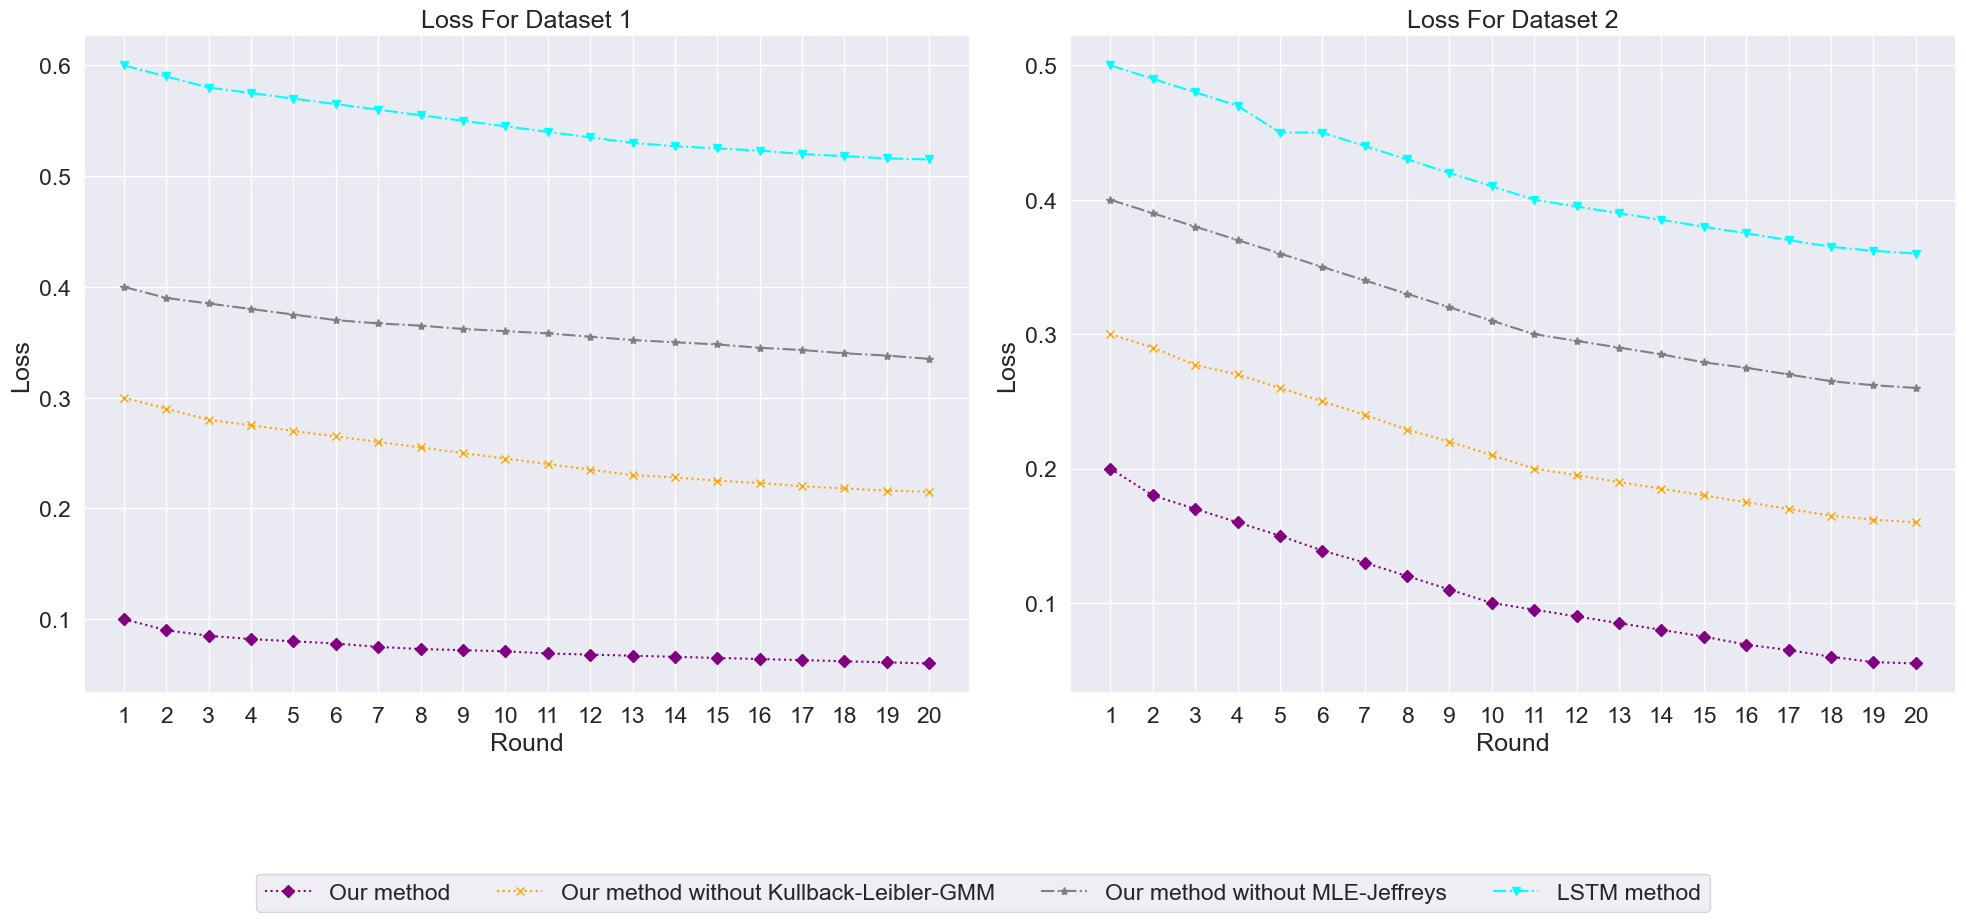

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
line1, = ax1.plot(rounds, Our_Loss_1, label='Our method',color='purple', marker='D', linestyle=':')
line2, = ax1.plot(rounds, OmwKL_Loss_1, label='Our method without Kullback-Leibler-GMM', color='orange', marker='x', linestyle='dotted')
line3, = ax1.plot(rounds, OmwMJ_Loss_1, label='Our method without MLE-Jeffreys', color='gray', marker='*', linestyle='-.')
line4, = ax1.plot(rounds, Tsm_Loss_1, label='LSTM method', color='cyan', marker='v', linestyle='dashdot')
ax1.set_title('Loss For Dataset 1')
ax1.set_xticks(rounds)
ax1.set_xlabel('Round')
ax1.set_ylabel('Loss')

line1, = ax2.plot(rounds, Our_Loss_2, label='Our method', color='purple', marker='D', linestyle=':')
line2, = ax2.plot(rounds, OmwKL_Loss_2, label='Our method without Kullback-Leibler-GMM', color='orange', marker='x', linestyle='dotted')
line3, = ax2.plot(rounds, OmwMJ_Loss_2, label='Our method without MLE-Jeffreys', color='gray', marker='*', linestyle='-.')
line4, = ax2.plot(rounds, Tsm_Loss_2, label='LSTM method', color='cyan', marker='v', linestyle='dashdot')
ax2.set_title('Loss For Dataset 2')
ax2.set_xticks(rounds)
ax2.set_xlabel('Round')
ax2.set_ylabel('Loss')

fig.legend(handles=[line1, line2,line3, line4], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=7)
plt.tight_layout()
plt.savefig('3.pdf', bbox_inches='tight')
plt.show()

C:\Users\17401\anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


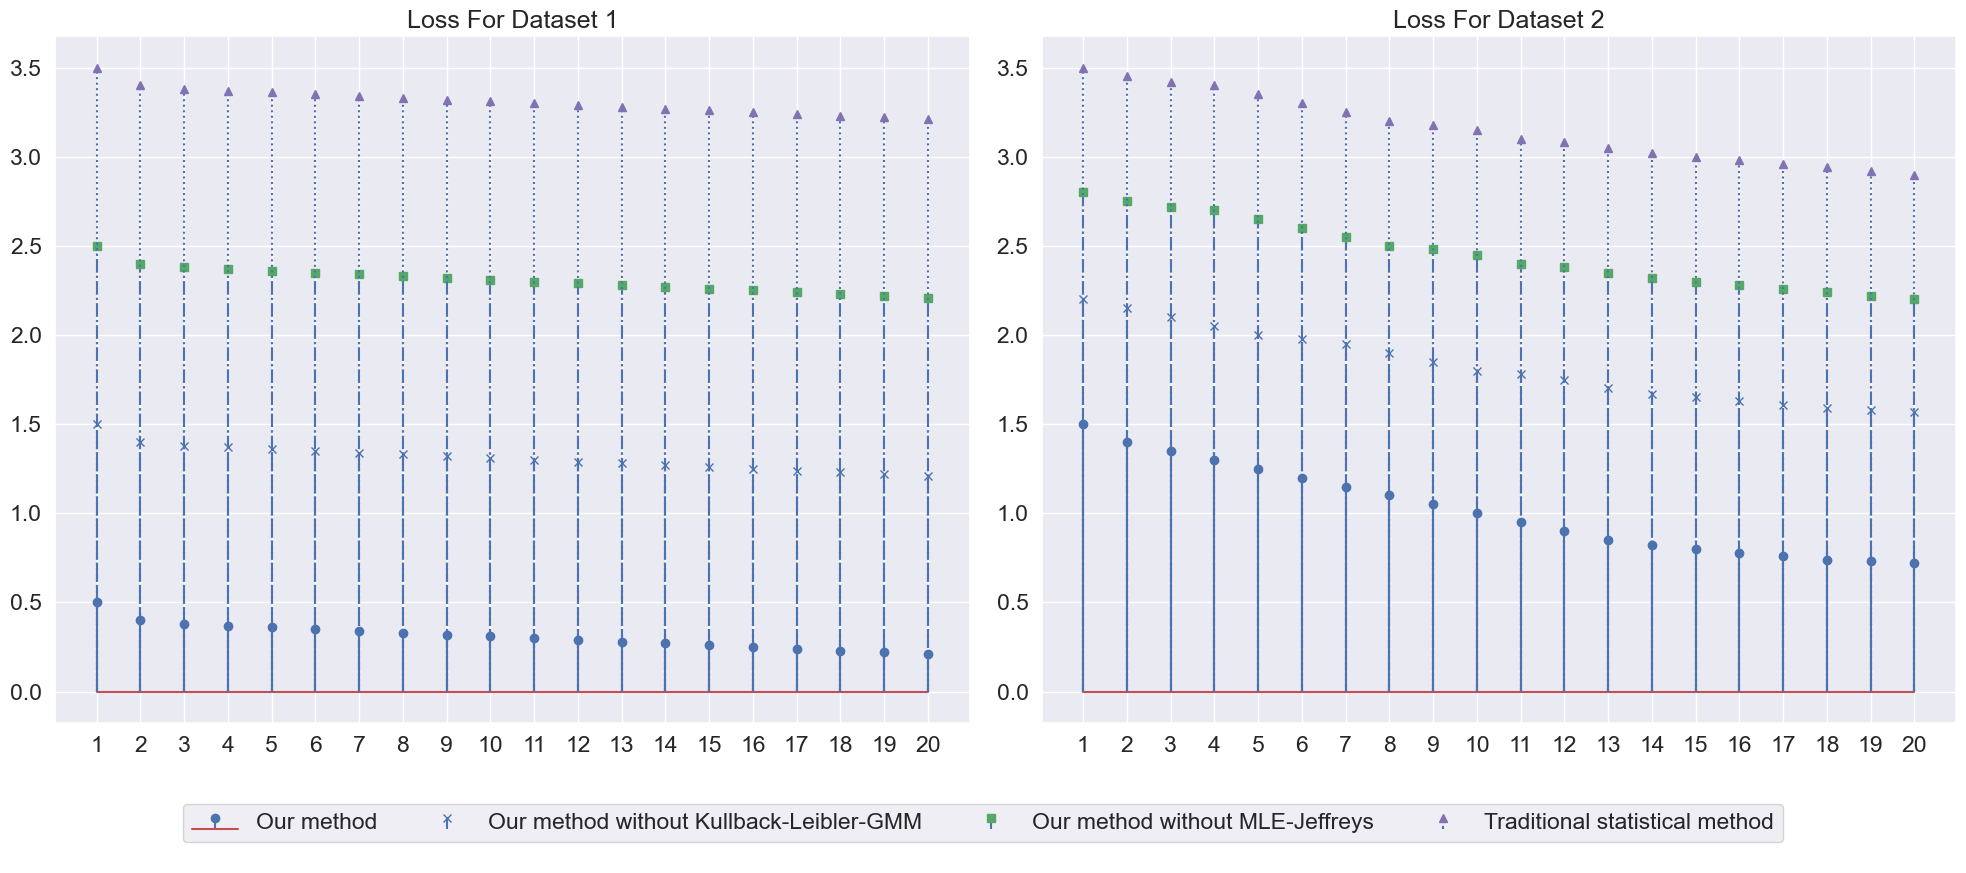

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
ax1.stem(rounds, Our_CVaR_1, label='Our method')
ax1.stem(rounds, OmwKL_CVaR_1, linefmt='--', markerfmt='x', basefmt=' ', label='Our method without Kullback-Leibler-GMM')
ax1.stem(rounds, OmwMJ_CVaR_1, linefmt='-.', markerfmt='s', basefmt=' ', label='Our method without MLE-Jeffreys')
ax1.stem(rounds, Tsm_CVaR_1, linefmt=':', markerfmt='^', basefmt=' ', label='Traditional statistical method')
ax1.set_xticks(rounds)
ax1.set_title("Loss For Dataset 1")

ax2.stem(rounds, Our_CVaR_2, label='Our method')
ax2.stem(rounds, OmwKL_CVaR_2, linefmt='--', markerfmt='x', basefmt=' ', label='Our method without Kullback-Leibler-GMM')
ax2.stem(rounds, OmwMJ_CVaR_2, linefmt='-.', markerfmt='s', basefmt=' ', label='Our method without MLE-Jeffreys')
ax2.stem(rounds, Tsm_CVaR_2, linefmt=':', markerfmt='^', basefmt=' ', label='Traditional statistical method')
ax2.set_xticks(rounds)
ax2.set_title("Loss For Dataset 2")

ax_legend = fig.add_axes([0.25, -0.1, 0.5, 0.1])
ax_legend.axis('off')  
handles, labels = ax1.get_legend_handles_labels()
ax_legend.legend(handles=handles, labels=labels, loc='center', ncol=7)
plt.tight_layout()
plt.savefig("4.pdf", bbox_inches='tight')
plt.show()

C:\Users\17401\anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


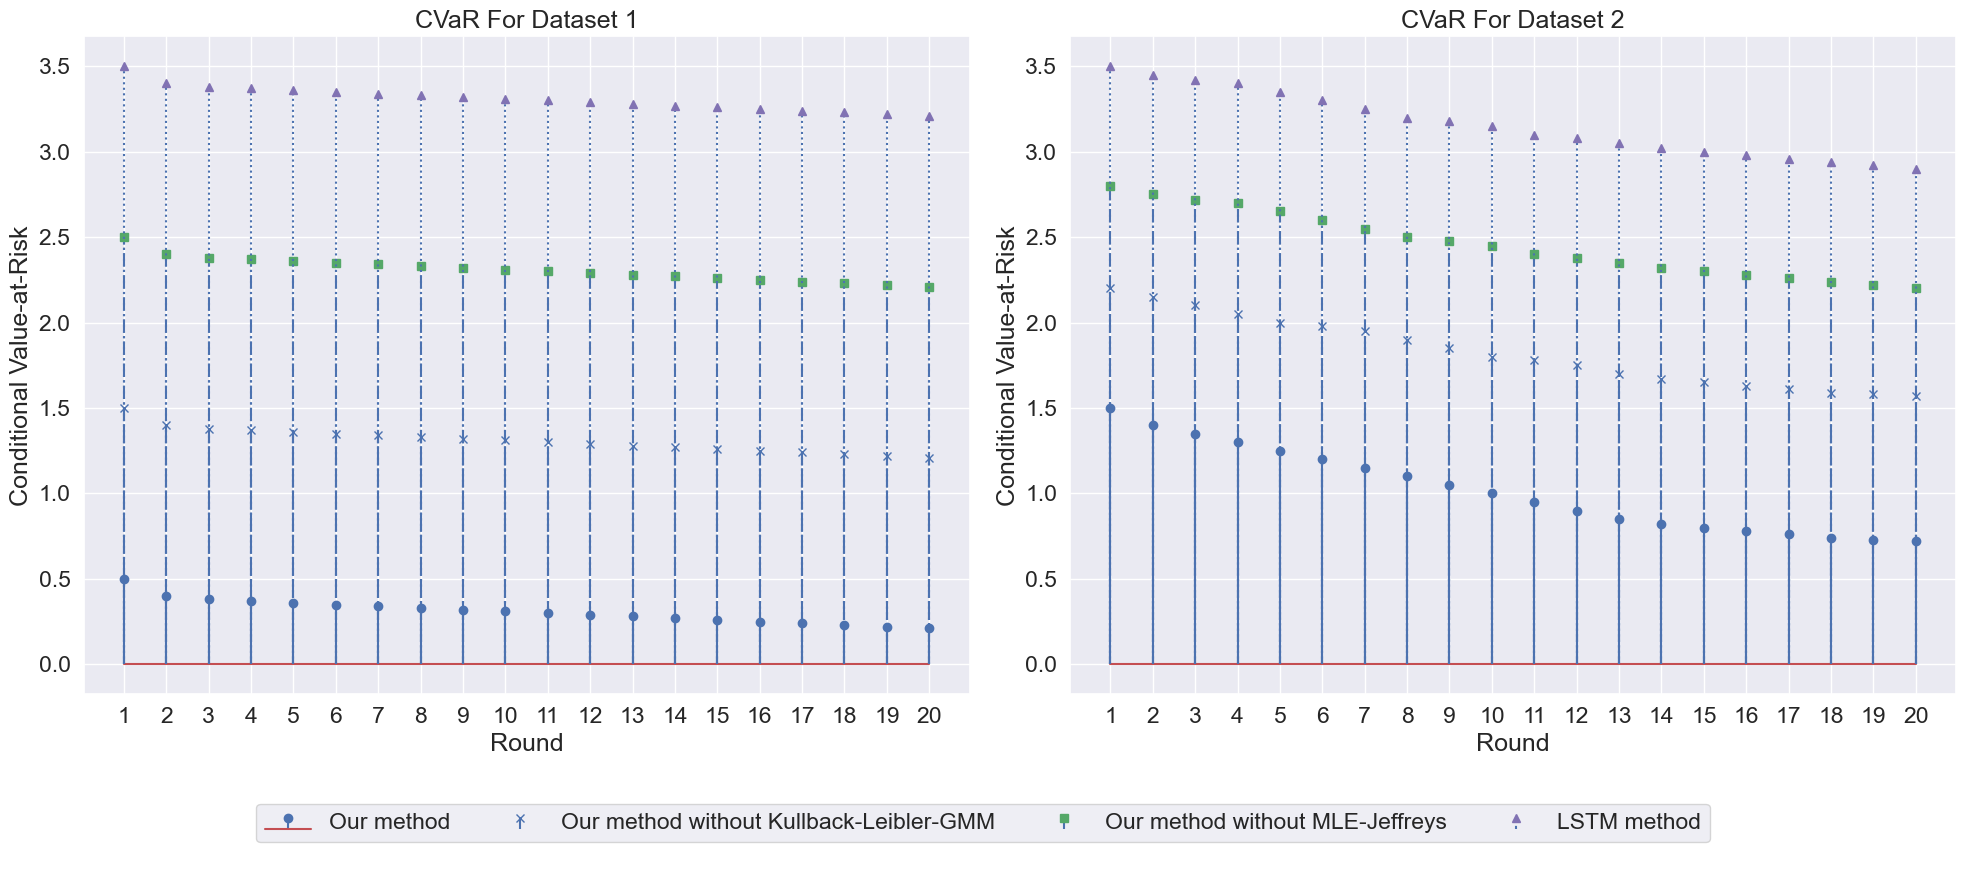

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
ax1.stem(rounds, Our_CVaR_1, label='Our method')
ax1.stem(rounds, OmwKL_CVaR_1, linefmt='--', markerfmt='x', basefmt=' ', label='Our method without Kullback-Leibler-GMM')
ax1.stem(rounds, OmwMJ_CVaR_1, linefmt='-.', markerfmt='s', basefmt=' ', label='Our method without MLE-Jeffreys')
ax1.stem(rounds, Tsm_CVaR_1, linefmt=':', markerfmt='^', basefmt=' ', label='LSTM method')
ax1.set_xticks(rounds)
ax1.set_title("CVaR For Dataset 1")
ax1.set_xlabel('Round')
ax1.set_ylabel('Conditional Value-at-Risk')

ax2.stem(rounds, Our_CVaR_2, label='Our method')
ax2.stem(rounds, OmwKL_CVaR_2, linefmt='--', markerfmt='x', basefmt=' ', label='Our method without Kullback-Leibler-GMM')
ax2.stem(rounds, OmwMJ_CVaR_2, linefmt='-.', markerfmt='s', basefmt=' ', label='Our method without MLE-Jeffreys')
ax2.stem(rounds, Tsm_CVaR_2, linefmt=':', markerfmt='^', basefmt=' ', label='LSTM method')
ax2.set_xticks(rounds)
ax2.set_title("CVaR For Dataset 2")
ax2.set_xlabel('Round')
ax2.set_ylabel('Conditional Value-at-Risk')

ax_legend = fig.add_axes([0.25, -0.1, 0.5, 0.1])
ax_legend.axis('off')  
handles, labels = ax1.get_legend_handles_labels()
ax_legend.legend(handles=handles, labels=labels, loc='center', ncol=7)

plt.tight_layout()
plt.savefig("4.pdf", bbox_inches='tight')
plt.show()


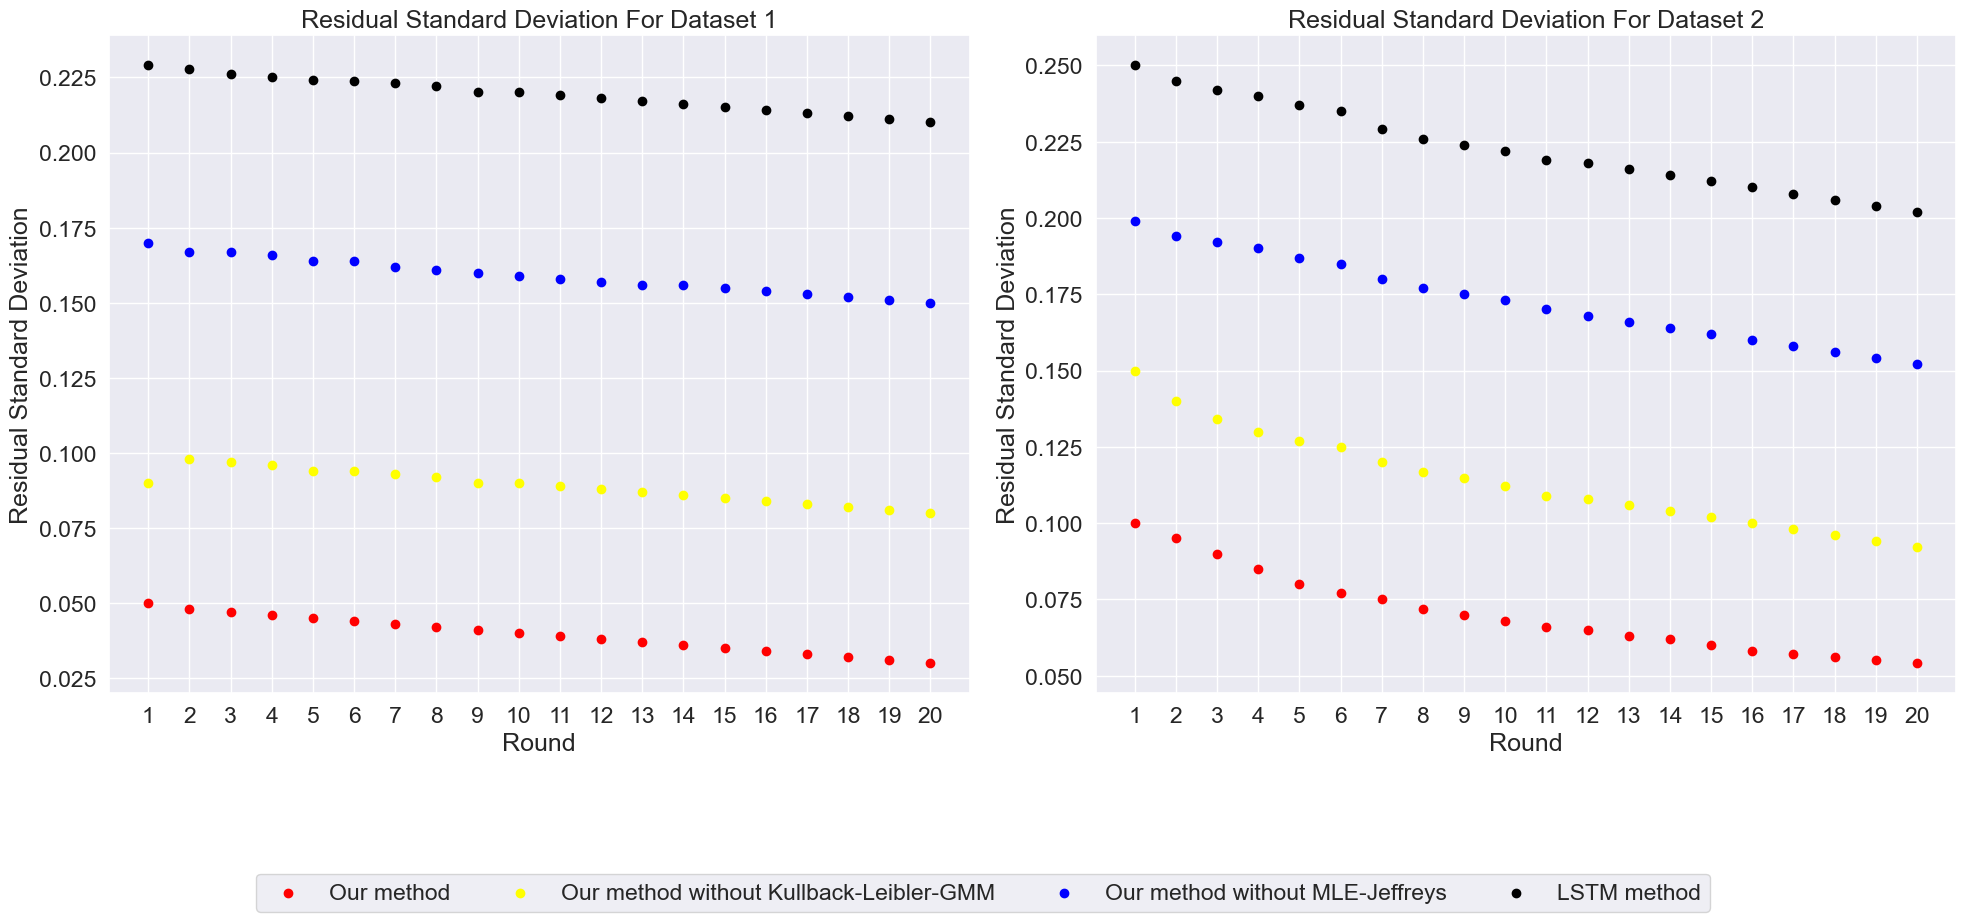

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
scatter1 = ax1.scatter(rounds, Our_Residual_1, alpha=1, color='red', label="Our method")
scatter2 = ax1.scatter(rounds, OmwKL_Residual_1, alpha=1, color='yellow', label="Our method without Kullback-Leibler-GMM")
scatter3 = ax1.scatter(rounds, OmwMJ_Residual_1, alpha=1, color='blue', label="Our method without MLE-Jeffreys")
scatter4 = ax1.scatter(rounds, Tsm_Residual_1, alpha=1, color='black', label="LSTM method")
ax1.set_xticks(rounds)
ax1.set_title("Residual Standard Deviation For Dataset 1")
ax1.set_xlabel('Round')
ax1.set_ylabel('Residual Standard Deviation')

scatter5 = ax2.scatter(rounds, Our_Residual_2, alpha=1, color='red', label="Our method")
scatter6 = ax2.scatter(rounds, OmwKL_Residual_2, alpha=1, color='yellow', label="Our method without Kullback-Leibler-GMM")
scatter7 = ax2.scatter(rounds, OmwMJ_Residual_2, alpha=1, color='blue', label="Our method without MLE-Jeffreys")
scatter8 = ax2.scatter(rounds, Tsm_Residual_2, alpha=1, color='black', label="LSTM method")
ax2.set_xticks(rounds)
ax2.set_title("Residual Standard Deviation For Dataset 2")
ax2.set_xlabel('Round')
ax2.set_ylabel('Residual Standard Deviation')
fig.legend(handles=[scatter1, scatter2, scatter3, scatter4], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=7)
plt.tight_layout()
plt.savefig('5.pdf', bbox_inches='tight')
plt.show()

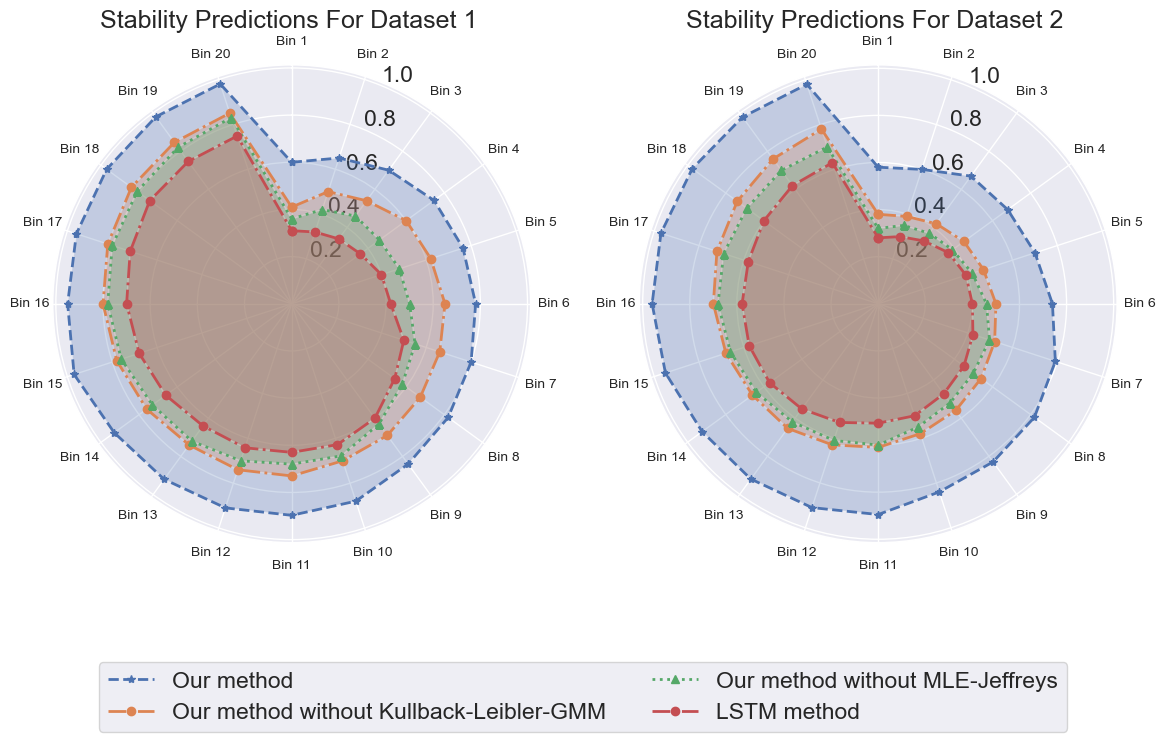

In [43]:
labels = [f'Bin {i+1}' for i in range(20)]
num_vars = 20
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
Our_Stability_1 = np.concatenate((Our_Stability_1, [Our_Stability_1[0]]))
OmwKL_Stability_1 = np.concatenate((OmwKL_Stability_1, [OmwKL_Stability_1[0]]))
OmwMJ_Stability_1 = np.concatenate((OmwMJ_Stability_1, [OmwMJ_Stability_1[0]]))
Tsm_Stability_1 = np.concatenate((Tsm_Stability_1, [Tsm_Stability_1[0]]))
angles += angles[:1]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), subplot_kw=dict(polar=True))
line1, = ax1.plot(angles, Our_Stability_1, linewidth=2, marker='*', linestyle='--', label='Our method')
ax1.fill(angles, Our_Stability_1, alpha=0.25)
line2, = ax1.plot(angles, OmwKL_Stability_1,marker='o', linewidth=2, linestyle='dashdot',  label='Our method without Kullback-Leibler-GMM')
ax1.fill(angles, OmwKL_Stability_1,alpha=0.25)
line3, = ax1.plot(angles, OmwMJ_Stability_1,marker='^', linewidth=2, linestyle=':',  label='Our method without MLE-Jeffreys')
ax1.fill(angles, OmwMJ_Stability_1,  alpha=0.25)
line4, = ax1.plot(angles, Tsm_Stability_1,   marker='o', linewidth=2, linestyle='dashdot',  label='LSTM method')
ax1.fill(angles, Tsm_Stability_1, alpha=0.25)
ax1.set_thetagrids(np.degrees(angles[:-1]), labels)
ax1.tick_params(axis='x', labelsize=10)  
ax1.set_theta_offset(np.pi / 2)
ax1.set_theta_direction(-1)
ax1.set_title("Stability Predictions For Dataset 1 ")

Our_Stability_2 = np.concatenate((Our_Stability_2, [Our_Stability_2[0]]))
OmwKL_Stability_2 = np.concatenate((OmwKL_Stability_2, [OmwKL_Stability_2[0]]))
OmwMJ_Stability_2 = np.concatenate((OmwMJ_Stability_2, [OmwMJ_Stability_2[0]]))
Tsm_Stability_2 = np.concatenate((Tsm_Stability_2, [Tsm_Stability_2[0]]))
line1, = ax2.plot(angles, Our_Stability_2,linewidth=2, marker='*', linestyle='--', label='Our method')
ax2.fill(angles, Our_Stability_2, alpha=0.25)
line2, = ax2.plot(angles, OmwKL_Stability_2, marker='o', linewidth=2, linestyle='dashdot', label='Our method without Kullback-Leibler-GMM')
ax2.fill(angles, OmwKL_Stability_2, alpha=0.25)
line3, = ax2.plot(angles, OmwMJ_Stability_2,marker='^', linewidth=2, linestyle=':', label='Our method without MLE-Jeffreys')
ax2.fill(angles, OmwMJ_Stability_2,  alpha=0.25)
line4, = ax2.plot(angles, Tsm_Stability_2,  marker='o', linewidth=2, linestyle='dashdot',  label='LSTM method')
ax2.fill(angles, Tsm_Stability_2,  alpha=0.25)
ax2.set_thetagrids(np.degrees(angles[:-1]), labels)
ax2.tick_params(axis='x', labelsize=10)  
ax2.set_theta_offset(np.pi / 2)
ax2.set_theta_direction(-1)
fig.legend(handles=[line1, line2, line3, line4], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
ax2.set_title("Stability Predictions For Dataset 2 ")

plt.tight_layout()
plt.savefig("6.pdf", bbox_inches='tight')
plt.show()
